<a href="https://colab.research.google.com/github/operaoflife/climate-change/blob/main/climatechange.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [ ]:
#loading dataset

df=pd.read_csv('C:\\Users\\Reema\\Downloads\\archive\\DailyDelhiClimateTrain.csv')
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
#summarizing the data set
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [ ]:
#data preprocessing

print("number of missing values in our temperature column: ",df.meantemp.isnull().sum())

number of missing values in our temperature column:  0


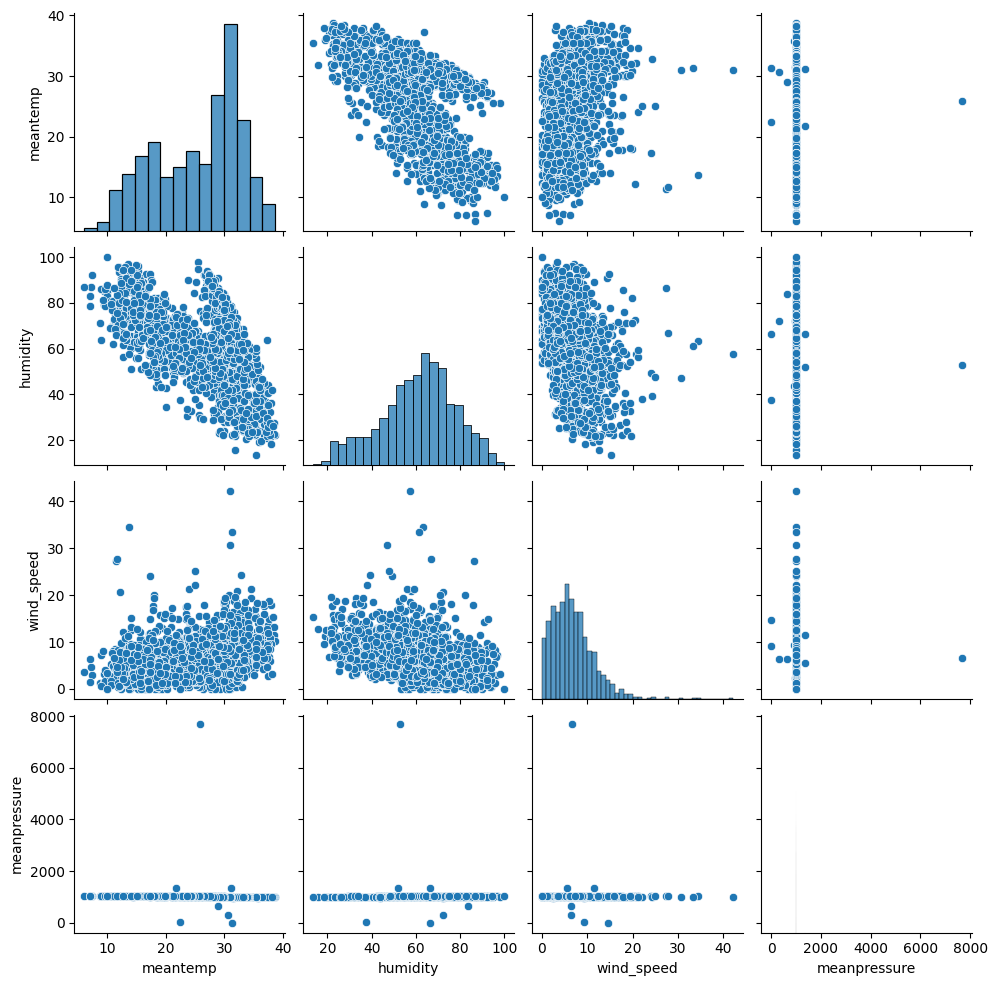

In [ ]:
#data visualization
sns.pairplot(df)

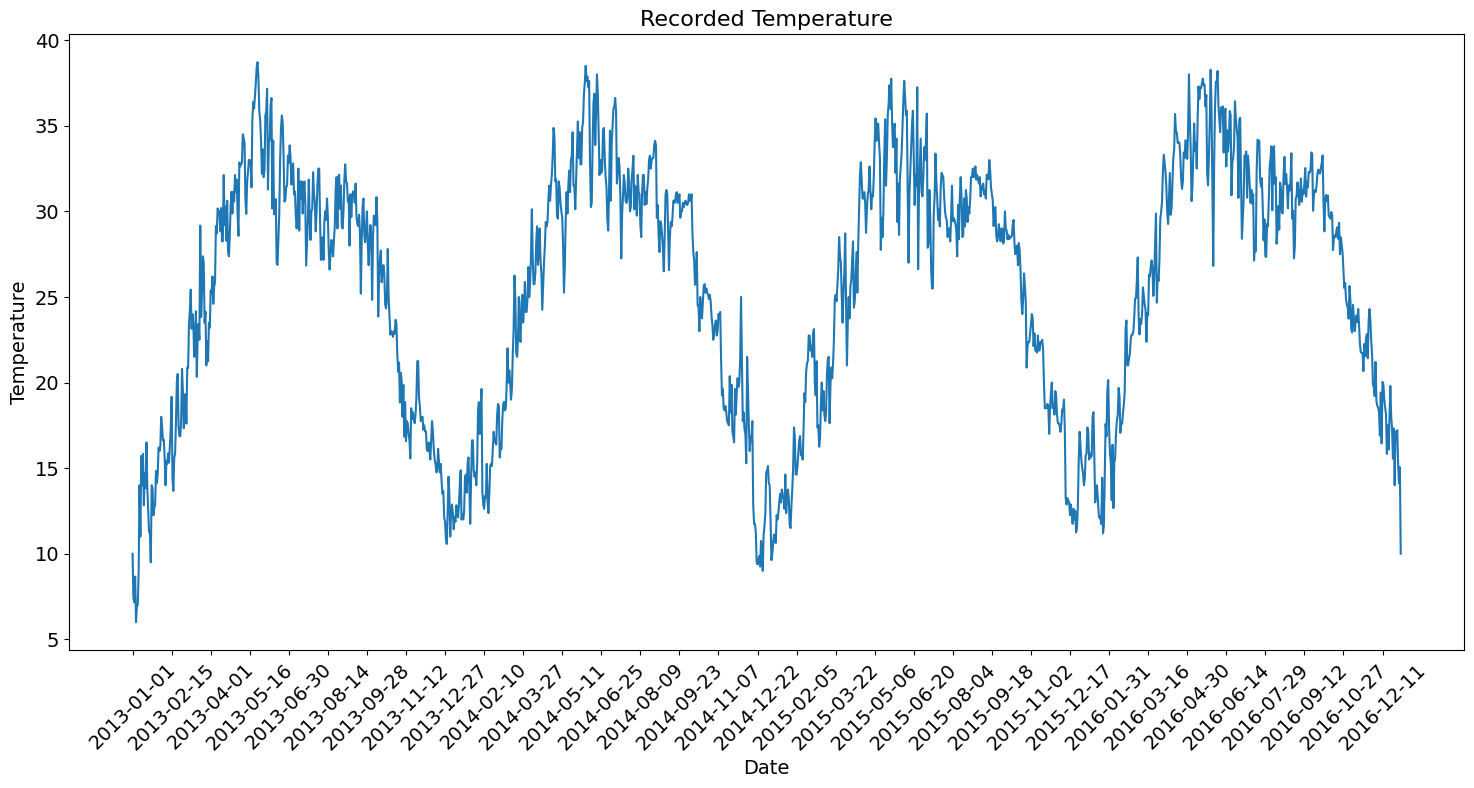

In [ ]:
#plot the recorded temperature over time

plt.figure(figsize=(18,8))
plt.plot(df.date,df['meantemp'])
plt.xlabel("Date",fontsize=14)
plt.ylabel("Temperature", fontsize=14)
plt.xticks(np.arange(0, len(df.date)+1,45), rotation=45,fontsize=14)
plt.yticks(fontsize=14)
plt.title("Recorded Temperature", fontsize=16)
plt.show()

Temperature Years on Record:  2013 2014 2015 2016


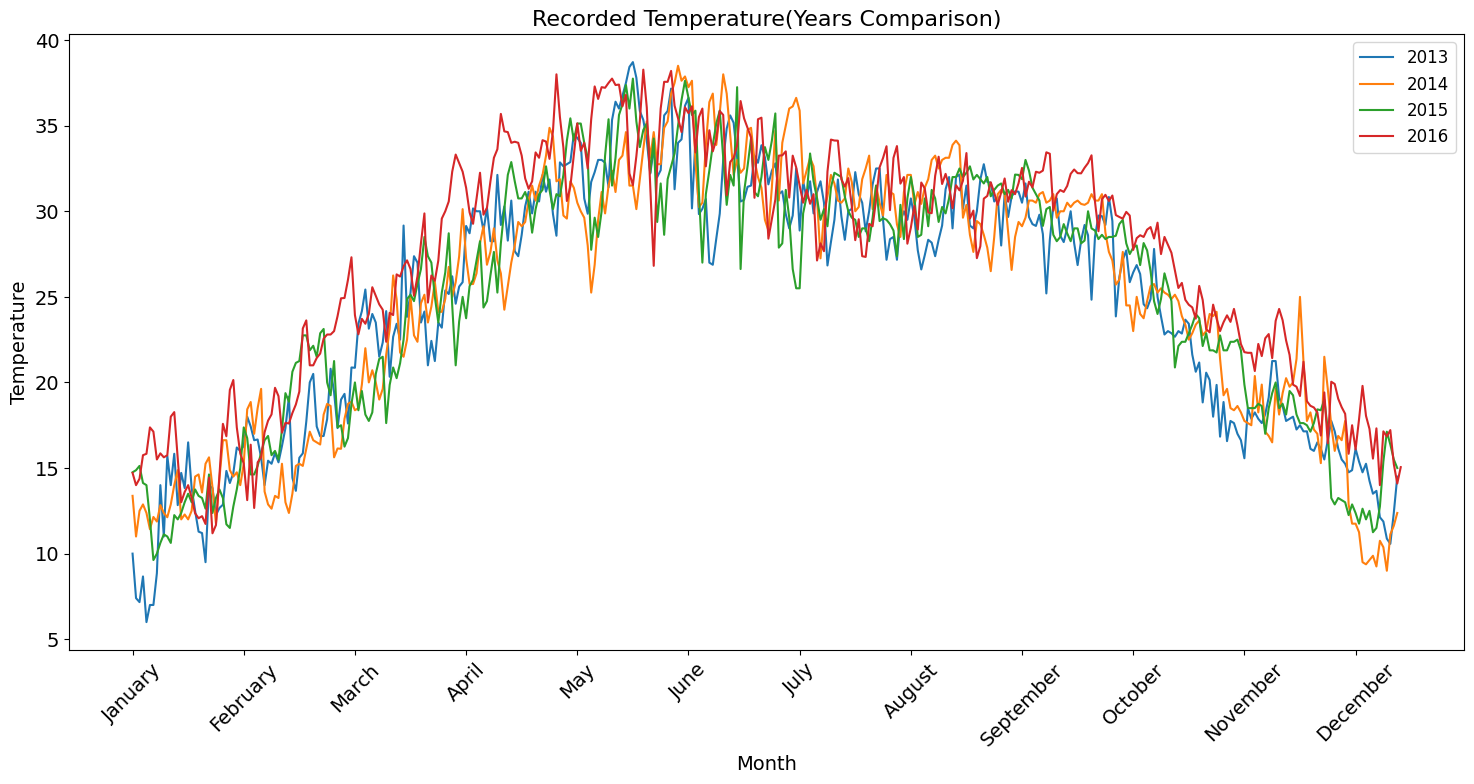

In [ ]:
#plot the temperature over months for each year ,comparing the recorded temperatures

plt.figure(figsize=(18,8))
dates=pd.to_datetime(df.date.iloc[:-1])
print("Temperature Years on Record: ", *dates.dt.year.unique())
for i in dates.dt.year.unique():
    plt.plot(df['meantemp'].iloc[:-1][dates.dt.year==i].values, label=i)

plt.xlabel("Month", fontsize=14)
plt.ylabel("Temperature", fontsize=14)
plt.xticks(np.arange(0, 365,32), labels=dates.dt.month_name().unique(),rotation=45,fontsize=14)
plt.yticks(fontsize=14)
plt.title("Recorded Temperature(Years Comparison)", fontsize=16)
plt.legend(fontsize=12)
plt.show()

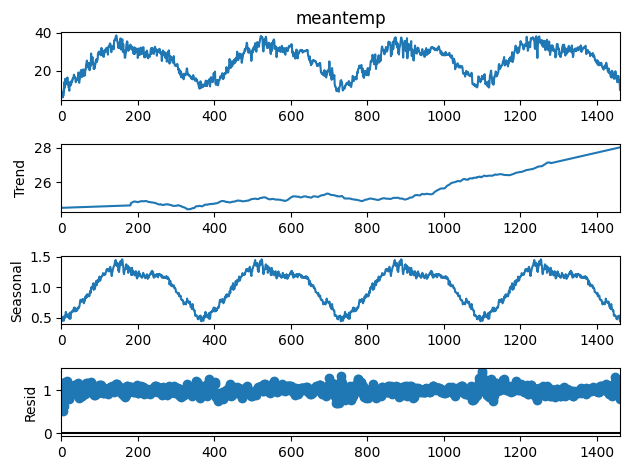

In [ ]:
#time series decomposition using multiplicative model

from statsmodels.tsa.seasonal import seasonal_decompose
decomp_mul=seasonal_decompose(df['meantemp'],model='multiplicative',extrapolate_trend='freq',period=365)
decomp_mul.plot()
plt.show()

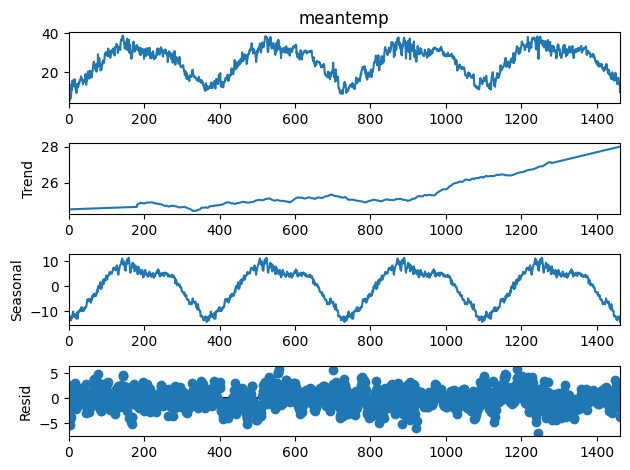

In [ ]:
#additive decomposition

decomp_add=seasonal_decompose(df['meantemp'],model='additive',extrapolate_trend='freq',period=365)
decomp_add.plot()
plt.show()

In [ ]:
#testing for stationarity and trend stationarity
import warnings
warnings.filterwarnings("ignore")


from statsmodels.tsa.stattools import adfuller, kpss

# Augmented Dickey Fuller (ADF) Test
result = adfuller(df['meantemp'].values, autolag='AIC')
print('ADF Statistic:', result[0], 'p-value:', result[1])

# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
result = kpss(df['meantemp'].values, nlags="auto", regression='c')
print('KPSS Statistic: ', result[0], 'p-value: ',result[1])

ADF Statistic: -2.0210690559206728 p-value: 0.27741213723016056
KPSS Statistic:  0.18786352260533618 p-value:  0.1


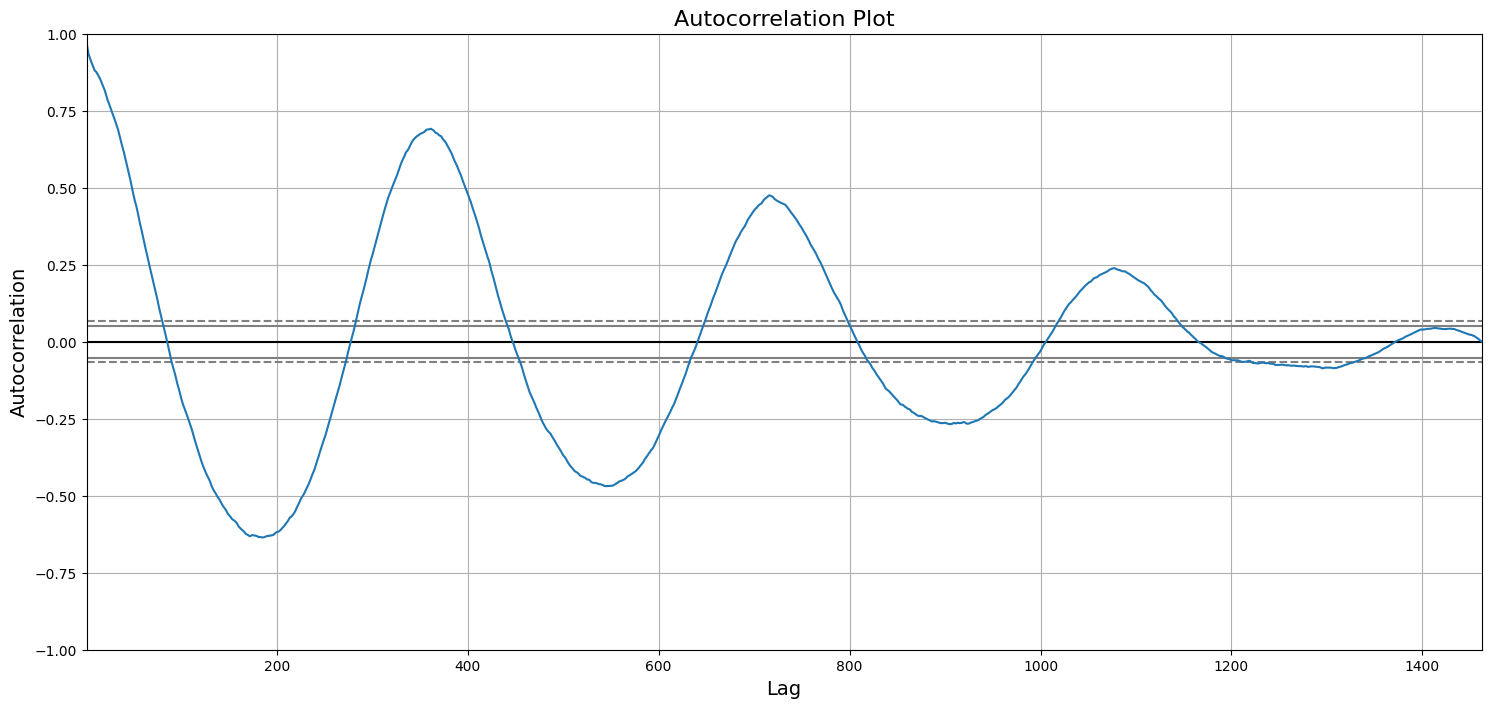

In [ ]:
#testing for time series seasonality

from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(18, 8))
autocorrelation_plot(df['meantemp'])
plt.title('Autocorrelation Plot', fontsize=16)
plt.xlabel("Lag", fontsize=14)
plt.ylabel("Autocorrelation", fontsize=14)
plt.show()

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1023
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1954.092
Date:                Tue, 06 Feb 2024   AIC                           3920.184
Time:                        07:27:14   BIC                           3949.761
Sample:                             0   HQIC                          3931.413
                               - 1023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0594      0.305     -0.194      0.846      -0.658       0.539
ar.L2          0.3430      0.190      1.803      0.071      -0.030       0.716
ar.L3         -0.0531      0.044     -1.211      0.2

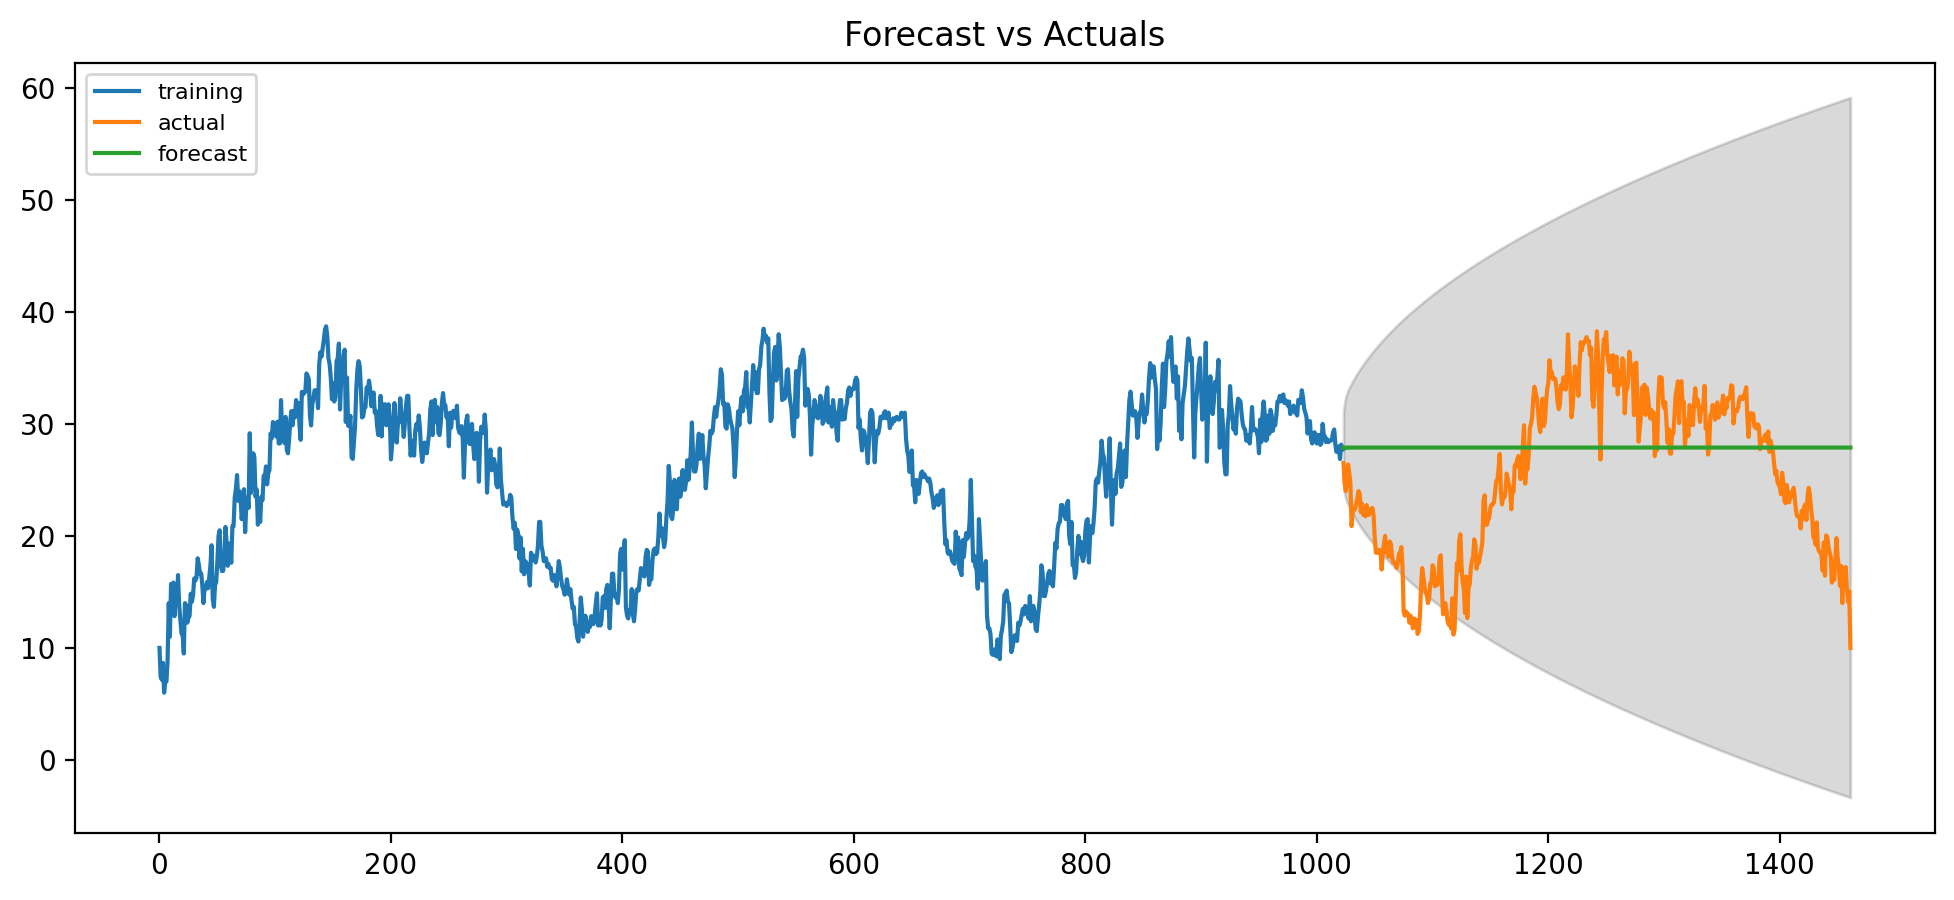

Mean Squared Error (ARIMA): 57.11284893331845
Root Mean Squared Error (ARIMA): 7.557304343039154
Mean Absolute Error (MAE): 6.38135154563147


In [ ]:
#time series analysis using ARIMA Model
import warnings
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")
train = df['meantemp'][:int(np.floor((len(df)/100)*70))]
test = df['meantemp'][int(np.floor((len(df)/100)*70)):]

model = ARIMA(train, order=(3,1,2))
fitted = model.fit()
print(fitted.summary())

fc = fitted.get_forecast(len(df['meantemp'][int(np.floor((len(df)/100)*70)):]))
conf = fc.conf_int(alpha=0.05) # 95% confidence

fc_series = pd.Series(fc.predicted_mean, index=test.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test.index)
arima_predictions = fitted.forecast(steps=len(test))
# Plot
plt.figure(figsize=(12,5), dpi=200)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

mse_arima = mean_squared_error(test, arima_predictions)
print(f'Mean Squared Error (ARIMA): {mse_arima}')
rmse_arima = np.sqrt(mse_arima)
print(f'Root Mean Squared Error (ARIMA): {rmse_arima}')

from sklearn.metrics import mean_absolute_error

# Assuming test and predictions are your actual and predicted values
mae = mean_absolute_error(test, arima_predictions)
print("Mean Absolute Error (MAE):",mae)

In [ ]:
features=df.columns
print("features in the dataset")
print(features)

features in the dataset
Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# New Section